In [16]:
import os
import os.path
import json

import numpy as np
import dlib
import cv2
from skimage import io
from PIL import Image, ImageDraw

from utils import *

from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
IMAGE_FORMATS = {'.jpg', '.jpeg', '.png'}

In [3]:
def get_images(path):
    return list(filter(lambda s: os.path.isfile(os.path.join(path, s)) and 
                       os.path.splitext(s)[1] in IMAGE_FORMATS, os.listdir(path)))


def get_folders(path):
    return list(filter(lambda s: os.path.isdir(os.path.join(path, s)), os.listdir(path)))

In [4]:
#Entry = ['subject', 'name', 'path'])
def grab_db_plain(path, divisor):
    res = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        ext = os.path.splitext(file)[1]
        if os.path.isfile(file_path) and ext in IMAGE_FORMATS:
            subject, name = file.split(divisor)
            res.append((path + subject, name, file_path))

    return res


def grab_db_folders(path):
    res = []

    for dir in os.listdir(path):
        dir_path = os.path.join(path, dir)
        if os.path.isdir(dir_path):
            for file in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file)
                ext = os.path.splitext(file)[1]
                if os.path.isfile(file_path) and ext in IMAGE_FORMATS:
                    res.append((path + dir, file, file_path))

    return res

def get_entry_subjects(entries):
    subjects = []
    for k in entries.keys():
        subjects.extend(list(set(map(lambda e: e[0], entries[k]))))
    return subjects


# Label images

In [14]:
#Create directories for label data
for dir in ['fei/','caltech_faces/','gt_db/','mine/']:
    path = base_dir + dir + 'labels/'
    if not os.path.exists(path):
        print('Creating {}'.format(path))
        os.makedirs(path)

Creating ./faces/fei/labels/
Creating ./faces/caltech_faces/labels/
Creating ./faces/mine/labels/


In [5]:
base_dir = './faces/'
entries = {
    'fei': grab_db_plain(base_dir + 'fei/', '-'),
    'caltech_faces': grab_db_folders(base_dir + 'caltech_faces/'),
    'gt_db': grab_db_folders(base_dir + 'gt_db/'),
    'mine': grab_db_folders(base_dir + 'mine/')
}

In [14]:
#Process photos
def label_bboxes_on_images(dirs=['fei', 'caltech_faces', 'gt_db', 'mine']):
    detector = dlib.get_frontal_face_detector()
    no_faces = []

    for dir in dirs:
        label_path = base_dir + dir + '/labels/'
        metadata = []

        for (subject, photo, filename) in entries[dir]:
            img = io.imread(filename)
            img = img[:,:,:3]    #remove alpha channel

            faces = list(detector(img, 1))

            if len(faces) == 0:
                no_faces.append(filename)
                continue

            face = faces[0]
            rect_meta = {'top':face.top(), 'bottom':face.bottom(), 
                         'right':face.right(), 'left':face.left()}
            full_meta = {'path':filename, 
                         'subjects':[ {'subject':subject, 'rect':rect_meta} ] }

            metadata.append(full_meta)

        with open(label_path + 'labels.txt', 'w+') as fs:
            json.dump(metadata, fs)

    print("Not detected on {} images".format(len(no_faces)))

    return no_faces

#no_faces = label_bboxes_on_images()
#with open('./faces/not_detected2.txt', 'w') as fs:
#    json.dump(no_faces, fs)

Not detected on 9 images


# Test feature map generation

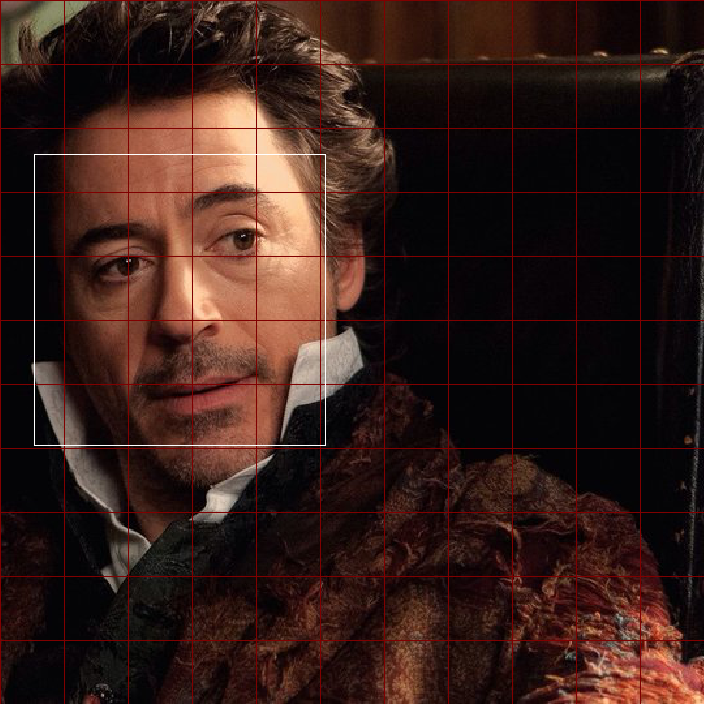

In [23]:
from PIL import Image, ImageDraw
photo_num = 30

#Load metadata
with open('faces/mine/labels/labels.txt', 'r') as f:
    a = json.load(f)
subj = a[photo_num]['subjects'][0]
rect = subj['rect']
top, bottom, left, right = rect['top'], rect['bottom'], rect['left'], rect['right']

#Load image
img = Image.open(a[photo_num]['path'])

#Crop
d = min(img.height, img.width)
scale = 704/d
img = img.resize((int(img.width*scale), int(img.height*scale)))
(top, bottom, left, right) = Resize((top, bottom, left, right), (scale,scale))

crop_rect = CleverRandomCropArea((top, bottom, left, right), img.size, crop_size=(704,704))
img = img.crop(crop_rect)
(top, bottom, left, right) = Crop((top, bottom, left, right), crop_rect)

# Draw grid
draw = ImageDraw.Draw(img)

cells = np.linspace(0, 1, 11 + 1)

for x in cells:
    line = ((x*704, 0), (x*704, img.height))
    draw.line(line, fill=128)
    
for y in cells:
    line = ((0, y*704), (img.width, y*704))
    draw.line(line, fill=128)

#Draw bbox
draw.rectangle((left, top,right, bottom))

del draw

img

In [24]:
#Testing, testing, 1, 2, 3...
n_classes = 0
for k in entries.keys():
    n_classes += len(list(set(map(lambda e: e[0], entries[k]))))

feature_map_size = (11,11)
subj_index = 0

feature_map = np.zeros((4+1+n_classes, feature_map_size[0], feature_map_size[1]), dtype=np.float32)

center_x = (left+right)/2/img.width
center_y = (top+bottom)/2/img.height


cells = np.linspace(0, 1, 11 + 1)
cell_index_x = np.argmax(cells > center_x)-1
offset_x = (center_x - cells[cell_index_x])/(cells[cell_index_x + 1] - cells[cell_index_x])

cells = np.linspace(0, 1, 11 + 1)
cell_index_y = np.argmax(cells > center_y)-1
offset_y = (center_y - cells[cell_index_y])/(cells[cell_index_y + 1] - cells[cell_index_y])

anchor = (1,1)  #TODO: another anchors
            
bbox_height = abs(top - bottom)
bbox_width = abs(right - left)

t_w = np.log(bbox_width/anchor[0])
t_h = np.log(bbox_height/anchor[1])

#Put everything into feature feature_map
feature_map[:5, cell_index_x, cell_index_y] = offset_x, offset_y, t_w, t_h, 1
feature_map[5 + subj_index, cell_index_x, cell_index_y] = 1

print("Cell index:", (cell_index_x, cell_index_y))
print("Bbox center offset: ({:.2f}, {:.2f})".format(offset_x,offset_y))
print("Bbox size: ({:.2f}, {:.2f}) vs actual size: ({}, {})".format(np.exp(t_w), np.exp(t_h), abs(top-bottom), abs(left-right)))

Cell index: (2, 4)
Bbox center offset: (0.80, 0.68)
Bbox size: (291.00, 291.00) vs actual size: (291, 291)


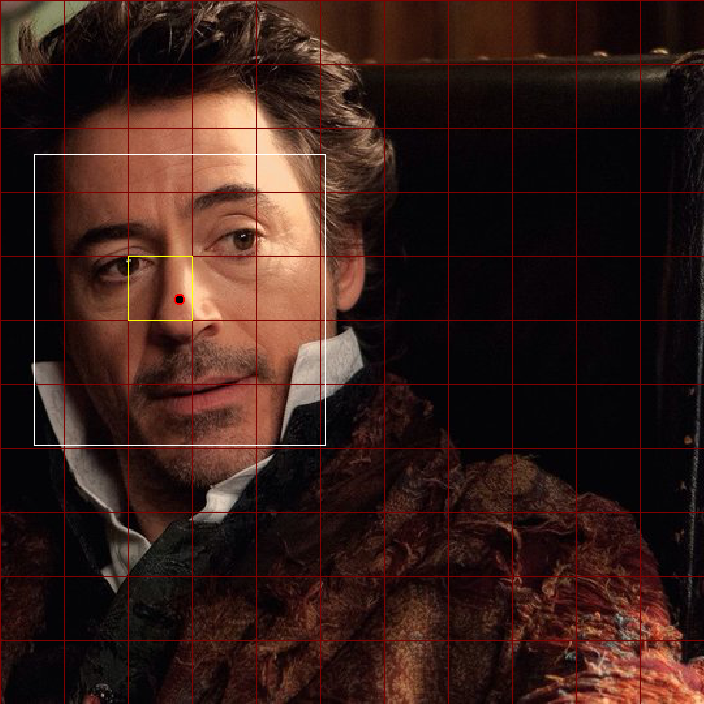

In [27]:
draw = ImageDraw.Draw(img)

s = 704

#Draw cell
draw.rectangle((cells[cell_index_x]*s, cells[cell_index_y]*s, 
               cells[cell_index_x+1]*s, cells[cell_index_y+1]*s), 
               outline="yellow")

#Draw actual center
draw.ellipse((center_x*s-5, center_y*s-5, center_x*s+5, center_y*s+5), fill="red")

#Draw offset within a cell
cell_size = cells[cell_index_x+1]*s - cells[cell_index_x]*s
draw.ellipse((cells[cell_index_x]*s + offset_x*cell_size - 3, 
              cells[cell_index_y]*s + offset_y*cell_size - 3, 
              cells[cell_index_x]*s + offset_x*cell_size + 3, 
              cells[cell_index_y]*s + offset_y*cell_size + 3), fill="black")
del draw

img

In [28]:
#(The only non-zero) slice of feature map
feature_map[:, cell_index_x, cell_index_y]

array([0.8046875, 0.6796875, 5.673323 , 5.673323 , 1.       , 1.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ], dtype=float32)

In [14]:
metadata = []

for dir in ['fei', 'caltech_faces', 'gt_db','mine']:
    with open('faces/' + dir + '/labels/labels.txt', 'r') as f:
        metadata.extend(json.load(f))

#Transform to dict for convenience
metadata = {img['path']: img['subjects'][0] for img in metadata}

In [17]:
bbox_scales = []
for path in metadata.keys():
    img = Image.open(path) 
    size = min(img.height, img.width)
    
    rect = metadata[path]['rect']
    top, bottom, left, right = rect['top'], rect['bottom'], rect['left'], rect['right']
    h = abs(top - bottom)
    w = abs(left - right)
    bbox_size = max(h,w)
    
    bbox_scales.append(bbox_size/size)

In [18]:
bbox_scales = np.array(bbox_scales)

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


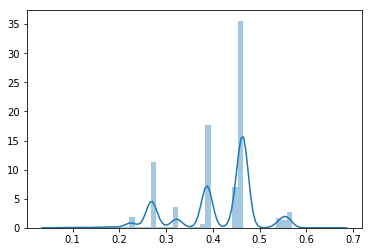

In [19]:
import seaborn as sns

sns.distplot(bbox_scales)

In [26]:
from sklearn.cluster import KMeans

clst = KMeans(n_clusters=3).fit(bbox_scales.reshape(-1, 1))
clst.cluster_centers_

array([[0.25510399],
       [0.4735798 ],
       [0.37655481]])

In [ ]:
240, 160, 60